The notebook gives the experiment reported in Fig. 3 (top left), where the univariate function  $f(x)=sin(x)$ is estimated at test points using APIS from corrupted training values in non-parametric kernel regression setting.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import kerlib
import copy
import time
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import inspect

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [2]:
start_time=time.time()
n=500
d=1
h=1

frac_k=0.1
k=int(n*frac_k)

train_sigma=2
X=np.random.normal(0,train_sigma, size=(n,d))
G=np.exp(-kerlib.getAllPairsDistances(X,X)/(2*h**2))


choice=0
a_star=kerlib.f(X,choice)
alpha_star=np.matmul(np.linalg.pinv(G),a_star)

y, corr_ind=kerlib.get_adv_corr3(a_star,frac_k)

noise_sigma=0.1
noise=np.random.normal(0,noise_sigma,size=(n,))
y=y+noise



In [3]:
#------Generate test data------#
n_test=1000
test_sigma=1
X_test=np.random.normal(0,test_sigma, size=(n_test,d))
#X_test=np.random.uniform(-2*sigma,2*sigma,size=(n_test,d))
y_test=kerlib.f(X_test,choice)

The best parameters are {'h': 1.0, 'frac_s': 0.16666666666666669, 'frac_k': 0.18333333333333335} with a score of -0.10


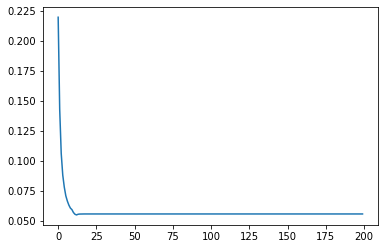

0.026092228535052407 0.00023537339597180912 125277278464.12993


In [4]:
#--------------APIS------------------#
# First cross validate for k, s and h values
frac_s_range = np.linspace( 0.05, 0.2, 10 )
frac_k_range = np.linspace( 0.05, 0.2, 10 )
h_range = np.logspace( -2, 2, 5 )
param_grid = dict( frac_s = frac_s_range, frac_k = frac_k_range, h = h_range )
cv = ShuffleSplit( n_splits = 5, test_size = 0.2, random_state = 42 )
# Exhaustive grid search is too expensive with 500 possible combinations
# Use randomized grid search instead with 50 grid points chosen uniformly
grid = RandomizedSearchCV(estimator= kerlib.APIS(), param_distributions=param_grid, n_iter = 50, cv = cv, refit = False )
grid.fit( X, y )
best = grid.best_params_

print("The best parameters are %s with a score of %0.2f" % (grid.best_params_, grid.best_score_))

apis = kerlib.APIS( frac_k = best["frac_k"], frac_s = best["frac_s"], h = best["h"] )
apis.fit( X, y, a_star = a_star, max_iter = 200 )
y_test_apis = apis.predict( X_test )
rmse_apis = np.linalg.norm( y_test - y_test_apis, 2 ) / np.sqrt( n_test )

plt.plot( apis.loss )
plt.show()

#approx. error of the estimator
apis_star = copy.deepcopy( apis )
apis_star.alpha = alpha_star
a_test_star = apis_star.predict( X_test )
rmse_approx = np.linalg.norm( y_test - a_test_star, 2 ) / np.sqrt( n_test )
print(rmse_apis, rmse_approx, np.linalg.norm( apis.alpha - alpha_star,2))

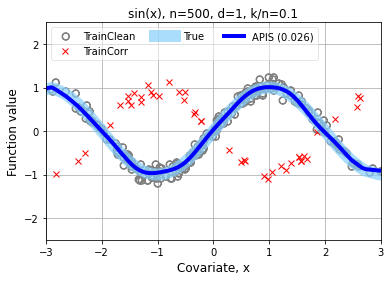

In [5]:
if d==1:
    ind=np.argsort(X, axis=0).ravel()
    ind_test=np.argsort(X_test,axis=0).ravel()
    ind_rand=np.random.choice(np.arange(n),int(n*0.5),replace=False)

    plt.plot(X[ind_rand,:],a_star[ind_rand]+noise[ind_rand],color='gray',marker=r'$\bigcirc$',ls='',label='TrainClean', markersize=8)
    plt.plot(X[corr_ind,:],y[corr_ind],color='red',marker='x',ls='',label='TrainCorr')
    plt.plot(X_test[ind_test,:],y_test[ind_test],color='lightskyblue',ls='-',label='True',linewidth=12,alpha = 0.7)
    plt.plot(X_test[ind_test,:],y_test_apis[ind_test],color='blue',ls='-', label='APIS ({:.3f})'.format(rmse_apis), linewidth=4)
    plt.legend(loc='upper left',prop = {'size': 10}, framealpha=0.5, ncol= 3)
    plt.title(kerlib.name+', n='+str(n)+', d='+str(d)+', k/n='+str(frac_k), size= 12)
    plt.xlabel('Covariate, x', size = 12)
    plt.ylabel('Function value', size = 12)
    plt.xlim(-3,3)
    plt.ylim(-2.5,2.5)
    plt.grid()
    plt.show()

In [6]:
print(f"Elapsed time: {time.time()-start_time:.2f} sec" )

Elapsed time: 12.51 sec
